In [1]:
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import RobustScaler
import pandas as pd
from ensemble import *

In [2]:
def filter_data(df):
    """
    Filter out genes with more then 80% missing features.
    """
    bool_index = df.apply(lambda x: sum(x == 0), axis=1) <= 80
    return df.loc[bool_index, ]

def process_x(x, n):
    """
    Normalize and remove feature correlation usind FA
    """
    gene_names = x.copy().index
    scaler = RobustScaler()
    print('Normalizing..')
    norm_x = scaler.fit_transform(x)
    print('Feature aggregation..')
    new_x = pd.DataFrame(FeatureAgglomeration(n_clusters=n).fit_transform(norm_x), index=gene_names)
    return new_x

def return_x_y(df, causal_genes, n=25):
    """
    Return X - df with filled name
    y - Series with supervided answers (1 or 0) for each gene
    """
    data = filter_data(df)
    y = df['gene_symbol'].map(
    lambda x: 1 if x in causal_genes['gene_symbol'].values else 0)
    print(f'We found {sum(y)} genes in list of causal genes!')
    if sum(y) <= 3:
        raise AssertionError("Numer of causal genes found <= 3. Add more causal genes.")
    x = process_x(df.fillna(0).set_index('gene_symbol'), n)
    return x, y  

def wmean_qc_coef(wmean, threshold, extended_list, true_genes):
    wmean_names = wmean['gene_symbol'].values
    pred_y = np.array(wmean['Probability'].values >= threshold)
    new_y = np.array(list(map(lambda gene: (gene in extended_list['gene_symbol'].values) & \
                        (gene not in true_genes['gene_symbol'].values), wmean_names))) #wmean_names
    if np.sum(pred_y) == 0:
        return 0
    Pr = np.sum(pred_y) / pred_y.size
    TP = np.sum(new_y & pred_y) # TP
    FN = np.sum(new_y) - TP # FN
    recall = TP/(TP+FN)
    coef = recall**2/Pr
    return coef
    
def perform_qc(wmean, extended_list, true_genes):
    threshold_range = [0.01, 0.1] + [i for i in range(1, 98)]
    qc_range = [wmean_qc_coef(wmean, threshold, extended_list, true_genes) for threshold in threshold_range]
    #print(qc_range)
    optimal_thr = [threshold_range[i] for i, j in enumerate(qc_range) if j == max(qc_range)][0]
    qc_coef = wmean_qc_coef(wmean, optimal_thr, extended_list, true_genes)
    print('qc_coef:', qc_coef)
    print('opt_threshols:', optimal_thr)
    return qc_range

def qc_score(true_y, pred_y):
    pred_y = np.array(pred_y)
    true_y = np.array(true_y)
    if np.sum(pred_y) == 0:
        return 0
    Pr = np.sum(pred_y) / pred_y.size
    TP = np.sum(true_y & pred_y) # TP
    FN = np.sum(true_y) - TP # FN
    recall = TP/(TP+FN)
    coef = recall**2/Pr
    return coef

def best_clf(model, X_train, y_train, param_dist):
    clf = GridSearchCV(model,
                       param_dist,
                       cv=3,
                       scoring = make_scorer(qc_score, greater_is_better=True),
                       iid=False,
                       n_jobs = -1)
    clf.fit(X_train, y_train)
    return clf.best_estimator_

In [3]:
true_genes = pd.read_csv('/home/nikita/Desktop/triple_phe/EA/GC/EA_causal.tsv',sep='\t')
extended_list = pd.read_csv('/home/nikita/Desktop/triple_phe/EA/GC/EA_extended.tsv',sep='\t')
infile = pd.read_csv('/home/nikita/Desktop/triple_phe/EA/postgap_check_new_features.tsv',sep='\t')

In [4]:
new_true_genes = pd.DataFrame({'gene_symbol':list(set(true_genes.gene_symbol) & set(infile.gene_symbol))})
train_genes = new_true_genes.iloc[:50]
alg_genes = new_true_genes.iloc[50:]

In [5]:
x, y = return_x_y(infile, train_genes, 60)
gene_names = x.index.copy() 

We found 50 genes in list of causal genes!
Normalizing..
Feature aggregation..


In [9]:
ens = EnsembleClassifier(x, y, MODELS, alg_genes, n_bootstrap=1)
ens.run_estimators()
wmean_ea = ens.best_scored_proba()

Logistic regression	
PU-score: 6.006974049128367

Support Vector Machine	
PU-score: 2.400755217925107

ADABoosting	
PU-score: 1.584433582779925

Random Forest	
PU-score: 5.4450120708154515

Decision Tree	
PU-score: 1.2177583498677247

Finding best combination	
Best combination is: ['Logistic regression']
PU-score: 6.006974049128367


(-50, 100)

(-10, 125)

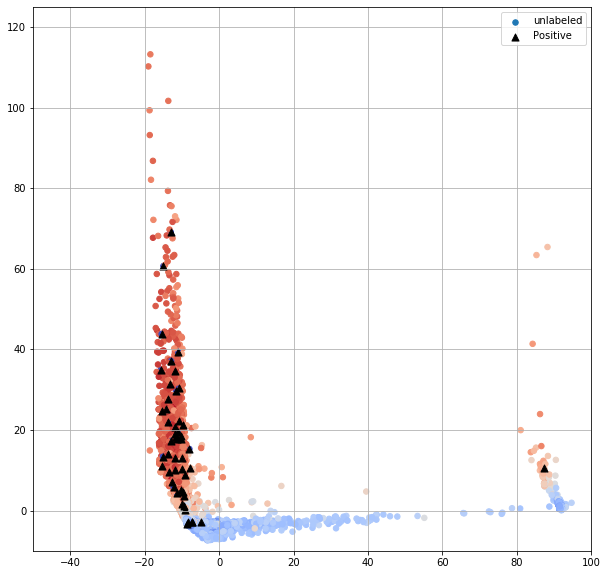

In [10]:
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
plot_x = pd.DataFrame(scaler.fit_transform(x))

pca = PCA(3)  # project from 64 to 2 dimensions
projected = pca.fit_transform(plot_x)

i = 0
j = 1
fig = plt.figure(figsize=(10, 10))
plt.scatter(projected[:,i], projected[:, j], c=wmean_ea.set_index('gene_symbol').reindex(x.index)['Probability'], 
                linewidth=1, s=30, alpha=1, cmap=plt.cm.get_cmap('coolwarm'), label='unlabeled')
plt.scatter(projected[y==1, i], projected[y==1, j], c='black', marker='^', linewidth=1, s=50, alpha=1, label='Positive')
plt.grid()
plt.legend()
axes = plt.gca()
axes.set_xlim([-50,100])
axes.set_ylim([-10,125])

array([28.25583728, 24.12820732, 25.56731481, ..., 85.16980943,
       45.90822685, 41.74714934])

In [34]:
wmean = pd.DataFrame({'gene_symbol':x.index.values, 'Probability': np.average(ens.probas, axis=0)})
wmean.Probability = wmean.Probability.replace(-1,100)
wmean

,gene_symbol,Probability
0,A1CF,28.255837
1,A4GNT,24.128207
2,AAAS,25.567315
3,AACS,32.574272
4,AADAT,69.018993
...,...,...
11133,ZYG11B,21.401668
11134,ZYX,21.555868
11135,ZZEF1,85.169809
11136,ZZZ3,45.908227


In [35]:
w_wmean = pd.DataFrame({'gene_symbol':x.index.values, 'Probability': np.average(ens.probas, axis=0, weights=ens.weights)})
w_wmean.Probability = w_wmean.Probability.replace(-1,100)
w_wmean

,gene_symbol,Probability
0,A1CF,29.210251
1,A4GNT,25.606751
2,AAAS,26.573358
3,AACS,33.153039
4,AADAT,69.889298
...,...,...
11133,ZYG11B,22.507444
11134,ZYX,22.671687
11135,ZZEF1,84.695850
11136,ZZZ3,46.161430


In [36]:
comb = wmean_ea
comb.Probability = comb.Probability.replace(-1,100)
comb

,gene_symbol,Probability
4038,GRIA1,90.789520
3083,EPHA5,90.674696
3591,FOXO3,90.538845
7658,RAB3C,90.470310
1467,CAMTA1,90.326763
...,...,...
9337,SULT1A1,100.000000
396,ANAPC4,100.000000
9056,SORCS3,100.000000
3580,FOXH1,100.000000


In [62]:
def return_y(df, ext, true):
    wmean_names = df.gene_symbol.values
    return np.array(list(map(lambda gene: (gene in ext.gene_symbol.values) & \
                        (gene not in true.gene_symbol.values), wmean_names)))

In [64]:
wmean_y = return_y(wmean, new_true_genes, extended_list)
w_wmean_y = return_y(w_wmean, new_true_genes, extended_list)
comb_y = return_y(comb, new_true_genes, extended_list)

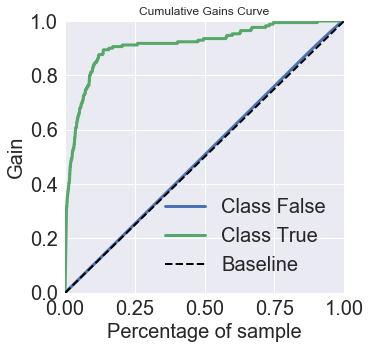

In [66]:
import scikitplot as skplt
import matplotlib.pyplot as plt
plt.style.use(u'seaborn')
new = np.array(list(map(lambda x: [100-x, x], wmean.Probability)))
skplt.metrics.plot_cumulative_gain(wmean_y, new, figsize=(5,5), text_fontsize=20)

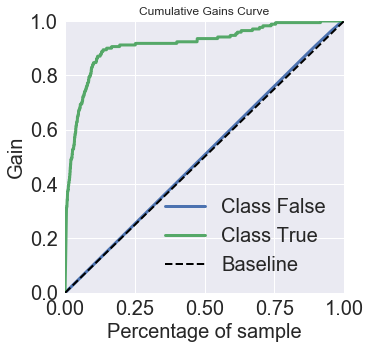

In [67]:
import scikitplot as skplt
import matplotlib.pyplot as plt
plt.style.use(u'seaborn')
new = np.array(list(map(lambda x: [100-x, x], w_wmean.Probability)))
skplt.metrics.plot_cumulative_gain(w_wmean_y, new, figsize=(5,5), text_fontsize=20)

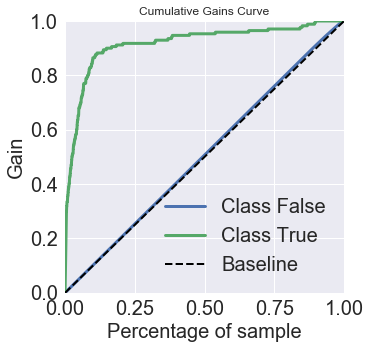

In [69]:
import scikitplot as skplt
import matplotlib.pyplot as plt
plt.style.use(u'seaborn')
new = np.array(list(map(lambda x: [100-x, x], comb.Probability)))
skplt.metrics.plot_cumulative_gain(comb_y, new, figsize=(5,5), text_fontsize=20)

In [70]:
perform_qc(w_wmean, extended_list, true_genes)

qc_coef: 4.33807570071354
opt_threshols: 62


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0001795977011494,
 1.0019791291831595,
 1.010891268832819,
 1.0225060421971504,
 1.0540667735097713,
 1.0868687983235872,
 1.1154657286416807,
 1.1725607267751095,
 1.2717214634500282,
 1.3523716984833196,
 1.4230945401982809,
 1.5013072594865124,
 1.5996041089054829,
 1.696558706419979,
 1.7939235640117261,
 1.8820273329553474,
 1.9798414087127998,
 2.1232279986862164,
 2.2565112513120797,
 2.343450253413086,
 2.4655097574019864,
 2.581948249288568,
 2.6943630781399164,
 2.7845093181243237,
 2.8785143094856394,
 3.0024942586478556,
 3.0755590750176838,
 3.1821682446284036,
 3.310767815048052,
 3.3783491295539743,
 3.5004772436270524,
 3.582444302656176,
 3.638418095130239,
 3.7331279343511987,
 3.799738817238777,
 3.84550332099238,
 3.910775652134769,
 3.985565691447339,
 4.083975667676383,
 4.107248832573158,
 4.08455745371226,
 4.114723072420278,
 4.185272259276977,
 4.2533

In [71]:
perform_qc(wmean, extended_list, true_genes)

qc_coef: 4.298821725522251
opt_threshols: 61


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0003592599245554,
 1.0029716343989195,
 1.0135590135590136,
 1.0302291855595123,
 1.0659113676904488,
 1.093305261409618,
 1.131214215273754,
 1.2063552953237895,
 1.293524086011071,
 1.3662801297907403,
 1.4335749934331496,
 1.5084884225352027,
 1.6121543031762748,
 1.7185124161570948,
 1.7701727238131217,
 1.8570850019955885,
 1.973753586525918,
 2.1144630133898112,
 2.22463604505163,
 2.295883604155716,
 2.4285478526267776,
 2.5320446596717785,
 2.632444968760998,
 2.713550518257487,
 2.8214410455452494,
 2.921104700206974,
 3.0215208547430805,
 3.0950592637857586,
 3.211447918982994,
 3.3336357620103456,
 3.435145084257006,
 3.5136741418122623,
 3.585907274432547,
 3.6220387300913677,
 3.7240418689316264,
 3.7288979182042303,
 3.8364613446938334,
 3.9195986090487787,
 3.9995419592139574,
 4.075120034290074,
 4.0971012134685925,
 4.0959020466492895,
 4.128152325267603,
 4.1852722

In [72]:
perform_qc(comb, extended_list, true_genes)

qc_coef: 4.345874104557232
opt_threshols: 65


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0001795977011494,
 1.000808697996226,
 1.0019791291831595,
 1.0043282236248872,
 1.008602734764104,
 1.0144821932780763,
 1.0202376010653953,
 1.027491180191288,
 1.0310708859227478,
 1.0556049211683,
 1.0798578262540675,
 1.1169387520273217,
 1.1498267448858182,
 1.186647977020899,
 1.2584717969204544,
 1.305292207356677,
 1.3766225249085635,
 1.4377650374977575,
 1.512646059555777,
 1.5959722218496244,
 1.7034046879939406,
 1.7694593813737325,
 1.8588892598892155,
 1.9679703415416603,
 2.071656087977494,
 2.178129965832752,
 2.2653441502603266,
 2.360833757423701,
 2.429801782531898,
 2.512422233037195,
 2.5773418970983872,
 2.640080258466121,
 2.742122779208169,
 2.8530468420697237,
 2.958582340727721,
 3.0728724590274377,
 3.1426702941115847,
 3.2117931388748655,
 3.328475512104771,
 3.421502624158338,
 3.501711011084962,
 3.559049713237793,
 3.653675038441825,
 3.7237459599055507,
 3.7809838595448775,
 3.834189553838214,
 3.

In [11]:
aggrx = pd.DataFrame(ens.probas.T, index=x.index).replace(-1,100)
aggrx

,0,1,2,3,4
gene_symbol,,,,,
A1CF,50.000000,60.452788,26.894142,29.310345,0.0
A4GNT,50.000000,40.952455,26.894142,44.632754,0.0
AAAS,50.000000,6.672721,26.894142,27.729730,0.0
AACS,50.000000,19.260194,26.894142,17.500000,0.0
AADAT,58.063452,61.686628,26.894142,77.500000,0.0
...,...,...,...,...,...
ZYG11B,50.000000,41.027146,26.894142,25.104895,0.0
ZYX,50.000000,62.227366,73.105858,47.492163,100.0
ZZEF1,61.965121,62.244664,73.105858,70.000000,100.0


In [12]:
from sklearn.calibration import CalibratedClassifierCV
WEIGHTS = {1:90, 0:10}
lr = LogisticRegression(solver='liblinear', penalty='l2', C=0.1, class_weight=WEIGHTS)
best_lr = best_clf(lr, aggrx, y, PARAM_DIST_LR)
lr.fit(aggrx,y)

LogisticRegression(C=0.1, class_weight={0: 10, 1: 90}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
lr.decision_function(aggrx)

array([ -6.78558355,  -8.65870179, -11.60972464, ...,  -3.8995595 ,
        -4.79486897,  -8.18511369])

In [60]:
lr.predict_proba(aggrx.iloc[list(y==0),])[:,1]

array([2.89214397e-05, 4.65349859e-04, 1.51481924e-05, ...,
       6.05824680e-02, 1.12645230e-03, 1.05526648e-03])

In [ ]:

stacking